<a href="https://colab.research.google.com/github/JaKuBisz/ZSU/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selected dataset
I have selected [Adult dataset](https://archive.ics.uci.edu/dataset/2/adult) for this project

The goal is to predict whether an adult makes over or under 50K USD a year.

In [62]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
from pandas.plotting import parallel_coordinates
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


In [63]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]
data = pd.read_csv(url, names=column_names, na_values=" ?", skipinitialspace=True)

# Exploratory Data Analysis
focus on understanding the dataset's characteristics, missing values, distribution of numerical and categorical variables, and relationships between variables.

### Data Description

Data source: [UCI Machine Learning Repository - Adult Dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data)

| Attribute       | Description |
|:----------------|:------------|
| age             | Age of the individual |
| workclass       | The type of employer the individual has (e.g., Private, Self-emp, Government, etc.) |
| fnlwgt          | Final weight. The number of people the census believes the entry represents |
| education       | The highest level of education achieved by the individual |
| education-num   | The highest level of education achieved in numerical form |
| marital-status  | Marital status of the individual |
| occupation      | The general type of occupation of the individual |
| relationship    | The individual's role in the family (e.g., husband, wife, son, daughter, etc.) |
| race            | Race of the individual |
| sex             | Gender of the individual |
| capital-gain    | Income from investment sources, apart from wages/salary |
| capital-loss    | Losses from investment sources, apart from wages/salary |
| hours-per-week  | Number of hours worked per week |
| native-country  | Country of origin for the individual |
| income          | Whether the individual makes more than $50K annually |


In [84]:
data

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


We have numerical and cathegorical values, we will need to encode these cathegorical values.

#### Basic information

In [85]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


We can see there are no missing values

#### Statistical summary

##### Numerical features

In [86]:
data.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Here we can get valuable insight into the dataset, as we get to know the data in it.
eg. The data was collected on people from 17-90 years old, who work from 1-99 hours per week, with 1 to 16 years of education, etc.

##### Cathegorical value statistics

In [87]:
columns_to_plot = ['income', 'workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

for feature in columns_to_plot:
    print(feature)
    print(data[feature].value_counts())
    print()

income
<=50K    24720
>50K      7841
Name: income, dtype: int64

workclass
Private             24094
Self-emp-not-inc     2688
Local-gov            2204
State-gov            1374
Self-emp-inc         1177
Federal-gov          1002
Without-pay            15
Never-worked            7
Name: workclass, dtype: int64

education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

marital_status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital_status, dtype: int64

occupation
Prof-specialty

Our exploration of the Adult dataset revealed several key insights:
- **Income Distribution:** Shows a clear divide, with a majority earning <=50K.
- **Workclass and Occupation:** Highlighted by a significant portion in private sectors and professional specialties, yet some categories, including 'workclass' and 'occupation', contain null values marked as "?".
- **Education:** Ranges widely, with most individuals having a high school or some college education, indicating a diverse educational background.
- **Marital Status and Relationship:** Dominated by married and never-married individuals, reflecting varied social statuses.
- **Demographics:** Predominantly white and male, suggesting certain demographic trends within the dataset.
- **Native Country:** The majority are from the United States, with sparse representation from other countries.

Null values in 'workclass', 'occupation', and 'native_country' imply missing data that requires careful handling during preprocessing to ensure accurate classification outcomes.

### Visualize numerical feature

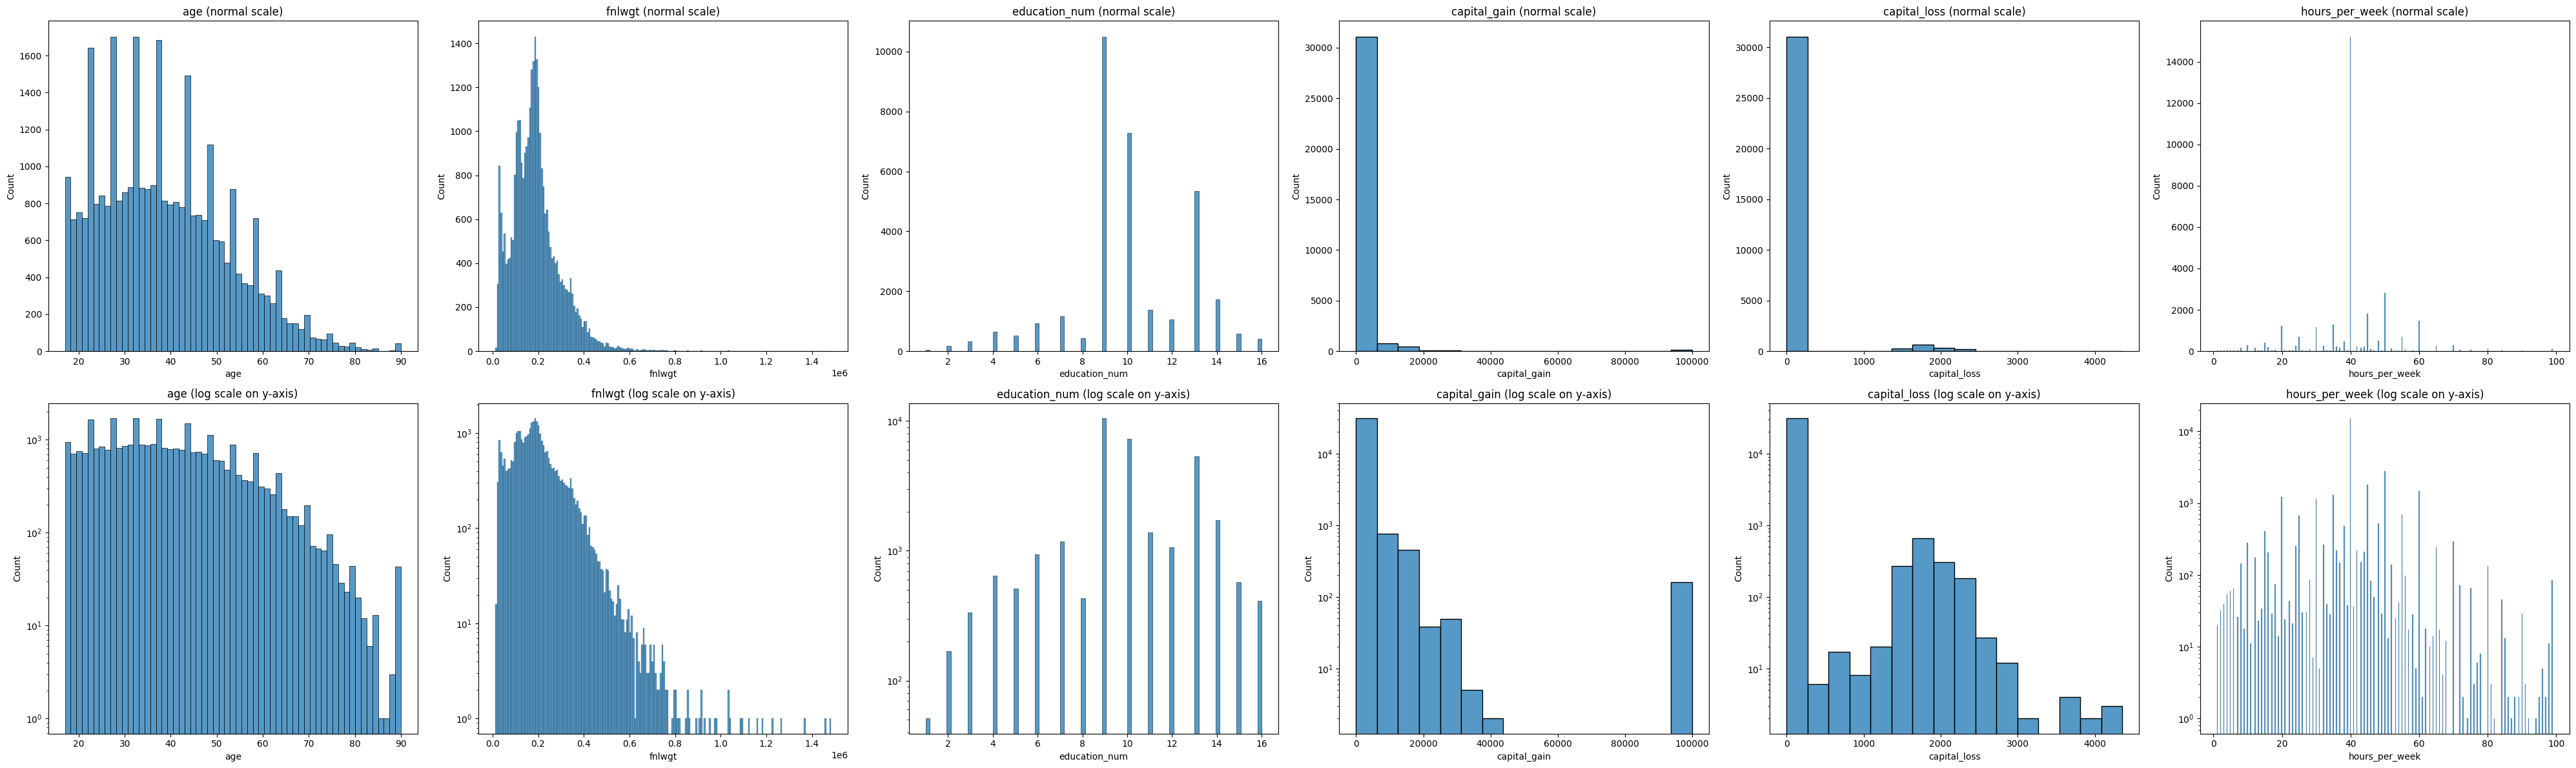

In [88]:
df_only_numeric = data.select_dtypes(np.number)

# Create the subplots
n_cols = df_only_numeric.shape[1]
fig, axes = plt.subplots(nrows=2, ncols=n_cols, figsize=(40, 12))

for i, column in enumerate(df_only_numeric):
    # First row for normal scale
    sns.histplot(df_only_numeric, x=column, ax=axes[0, i]).set_title(f'{column} (normal scale)')

    # Second row for log scale on y-axis
    sns.histplot(df_only_numeric, x=column, ax=axes[1, i]).set_yscale('log')
    axes[1, i].set_title(f'{column} (log scale on y-axis)')

plt.tight_layout()
plt.show()



Here we can clearly see the count distributions, its devided into 2 rows, 1st one is scaled normally and 2nd one uses Logarhytmic scaling on Y-axis - count axis, to better visualize capital gains and losses.

From these histograms we can clearly see, that scaling the data will be necessary.

We can see that the majority of data gathered is from people from 24-50 years old. Majority has education of 9-10 years.

Also we can see that the age and fnlwgt histograms skew left.


The visual examination of the histograms provides us with a two-tiered perspective on the data:

- The **first row** presents the distributions under normal scaling, which offers a general overview.
- The **second row** applies a logarithmic scale to the Y-axis, which enhances the visualization of capital gains and losses, revealing patterns that might be lost in a linear scale due to the presence of extreme values.

### Observations and Implications

- **Scaling Necessity:** The histograms underscore the need for scaling the data. The logarithmic transformation, in particular, brings to light the wide range of values within capital gains and losses, advocating for normalization to ensure these features contribute proportionately to the analysis.

- **Demographic Insights:** The age distribution indicates that the bulk of the dataset encompasses mainly individuals aged between 24 to 50 years. This age range likely represents the active workforce.

- **Educational Attainment:** A significant portion of the population exhibits 9 to 10 years of education, which may correspond to high school completion and some college education.

- **Data Skewness:** There is a noticeable left skew in the histograms for both age and `fnlwgt`, suggesting a higher concentration of younger individuals in the dataset and a tendency towards lower final weight values.

These insights are pivotal as they direct us towards meaningful preprocessing steps such as normalization, and they also highlight demographic trends that could be important for subsequent analyses.

In [89]:
capital_gain_zeros = (data['capital_gain'] == 0).sum()
capital_loss_zeros = (data['capital_loss'] == 0).sum()

print(f"capital_gain: {capital_gain_zeros} instances of 0")
print(f"capital_loss: {capital_loss_zeros} instances of 0")

capital_gain: 29849 instances of 0
capital_loss: 31042 instances of 0


- **Prevalence of Non-Traders:** The dominant mode at 0 reflects that the majority of participants in the dataset did not engage in investment trading activities that would result in capital gains or losses.

This observation is highlights area of financial among the participants, which may correlate with other socioeconomic factors under study.

Overview of Modes

In [90]:
# Calculate the mode for each column and pick the first mode if there are multiple
mode_values = data.mode().iloc[0]
print(mode_values)

age                             36.0
workclass                    Private
fnlwgt                        123011
education                    HS-grad
education_num                    9.0
marital_status    Married-civ-spouse
occupation            Prof-specialty
relationship                 Husband
race                           White
sex                             Male
capital_gain                     0.0
capital_loss                     0.0
hours_per_week                  40.0
native_country         United-States
income                         <=50K
Name: 0, dtype: object


The dataset's mode values highlight typical characteristics of the most frequent participant profile:

- **Age:** 36 years, suggesting a middle-aged workforce.
- **Workclass:** Predominantly employed in the private sector.
- **Education:** Most individuals have completed high school (HS-grad), with 9 years of education being the most common.
- **Marital Status:** A significant number are married to a civilian spouse.
- **Occupation:** The professional specialty field is the most common job type.
- **Relationship Status:** Many are husbands, reflecting the dataset's gender and marital status bias.
- **Race:** The majority are white, indicating racial demographics.
- **Sex:** Male is the predominant gender.
- **Capital Gain and Loss:** Both are most frequently 0, showing a lack of investment activity for the majority.
- **Hours per Week:** A standard full-time workload of 40 hours.
- **Native Country:** The vast majority reside in the United States.
- **Income:** Most earn <=50K annually.

These modes offer a snapshot into the demographic, occupational, and financial status of the dataset's typical respondent.


#### Histograms for numerical features

#### Box plots for numerical features vs income

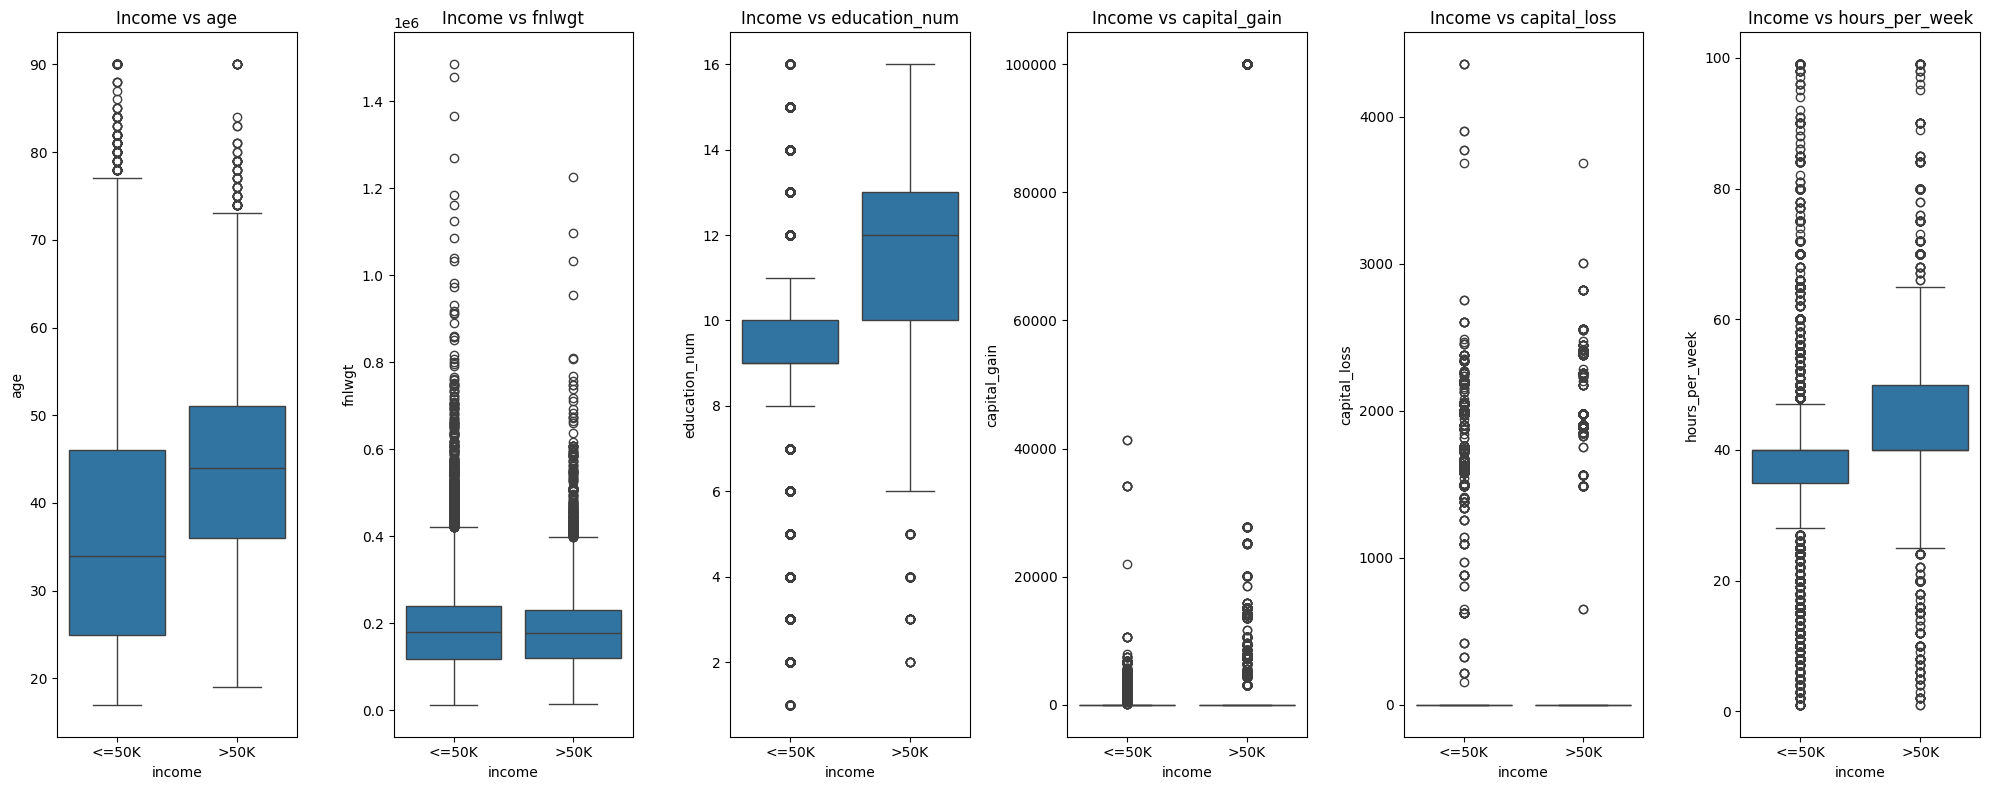

In [91]:
# Columns to plot
columns_to_plot = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# Set up the matplotlib figure
plt.figure(figsize=(20, 8))

# Create subplots
for i, col in enumerate(columns_to_plot):
    ax = plt.subplot(1, len(columns_to_plot), i + 1)  # 1 row, n columns, ith subplot
    sns.boxplot(x='income', y=col, data=data, ax=ax)
    ax.set_title(f'Income vs {col}')

# Adjust layout for better fit
plt.tight_layout()
plt.show()


Our analysis suggests potential attributes that could be important for future tasks, especially in clustering related to income levels:

- **Education:** There's an observed correlation between education length and income. More than 10 years of education often aligns with incomes above $50K, hinting at education's role in economic outcomes.

- **Worked Hours:** The number of hours worked per week also appears to influence income, with longer hours potentially indicating higher income levels.

- **Age:** Age shows a subtler correlation with income, suggesting it might be worth exploring further in predictive models.

**Implications**

These observations suggest that education, worked hours, and age could be valuable features in future analyses aimed at understanding income levels. Their inclusion might improve the accuracy and relevance of clustering efforts, offering insights into how certain socioeconomic factors impact income.



#### Visualizations for categorical features

Overview of categorical values distribution

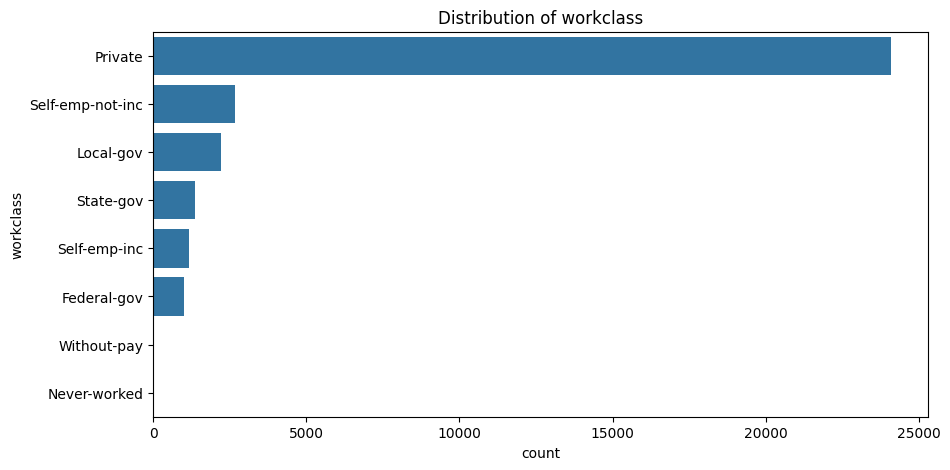

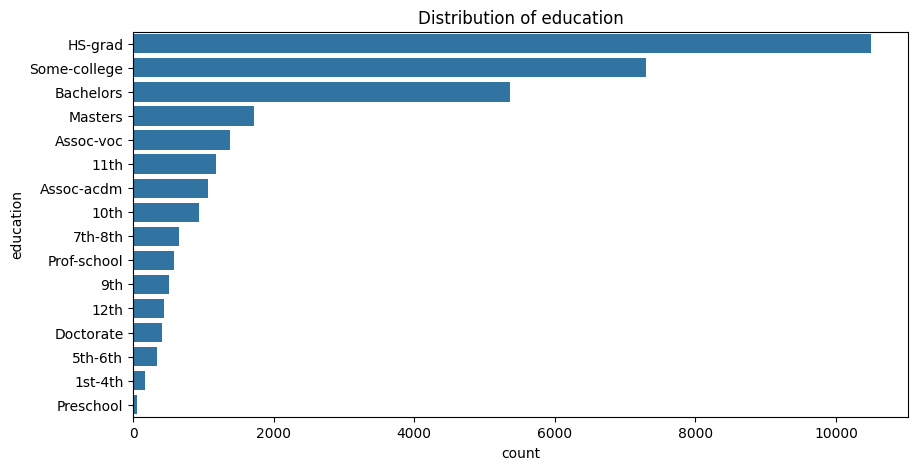

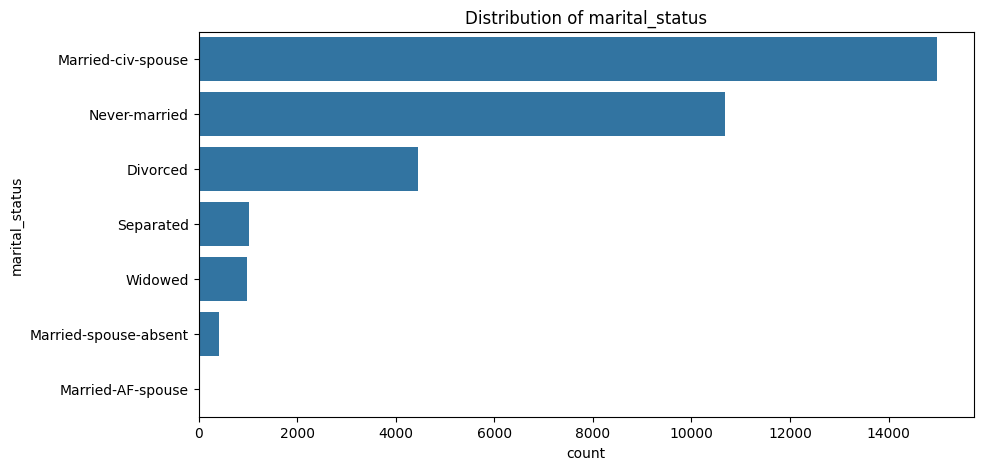

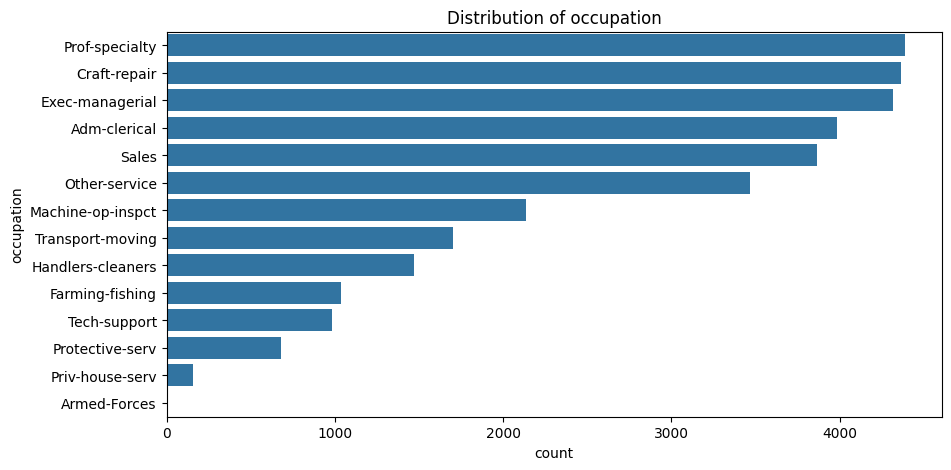

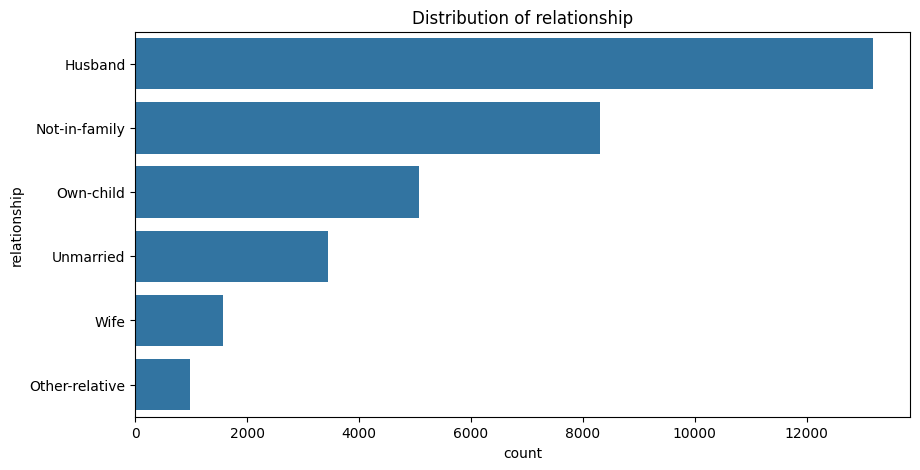

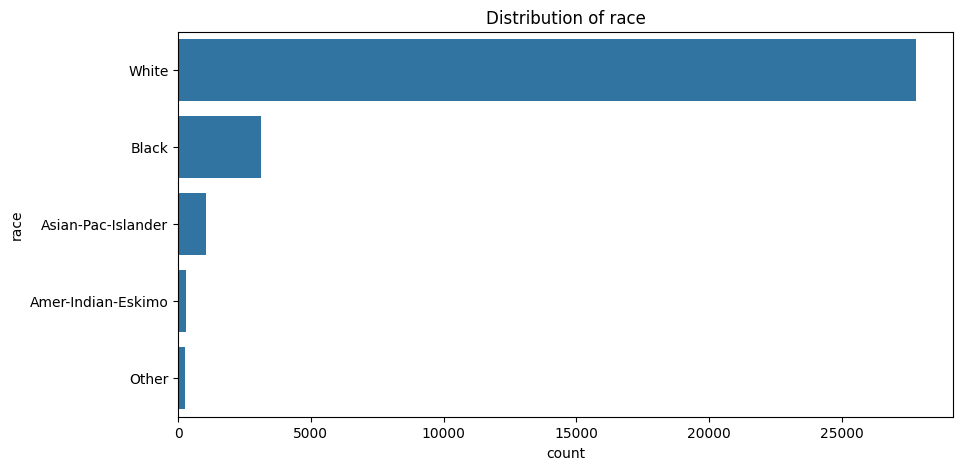

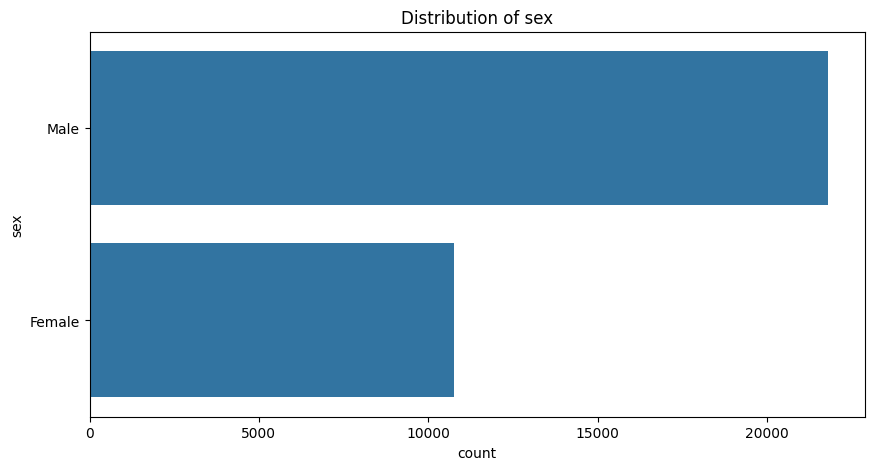

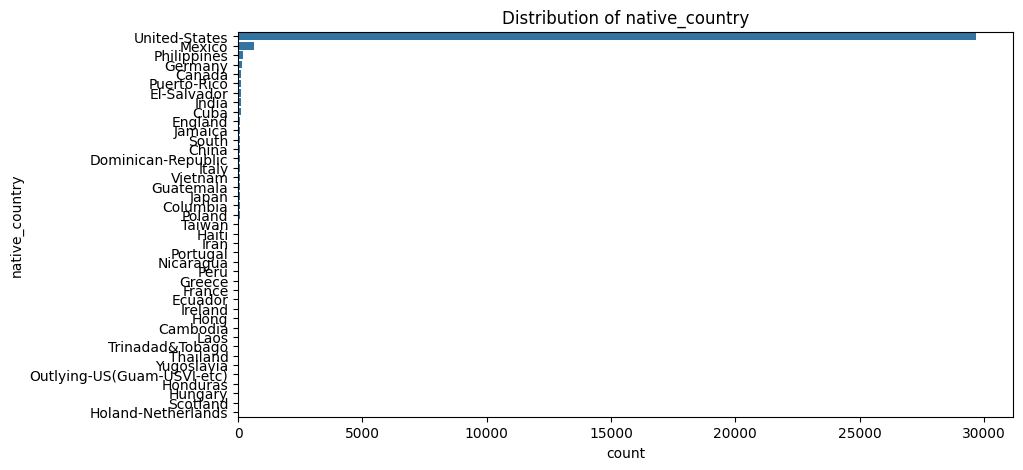

In [92]:
for col in ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=col, data=data, order = data[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()


### Data preprocessing

#### Handle null values

Features workclass, occupation and native_country contain "?" which is a null values, which we need to handle.


In [93]:
data.replace('?', np.NaN, inplace = True)
nan_counts = data.isnull().sum()
print(nan_counts)

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


In [94]:
data.fillna(method = 'ffill', inplace = True)
nan_counts = data.isnull().sum()
print(nan_counts)

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


We successfully replaced '?' characters with null values in our dataset and confirmed these changes.

We applied the 'forward fill' method to handle these nulls. This technique fills missing values with the last known non-null value in the column.


#### Encoding categorical variables

To prepare our dataset for clustering, we'll encode categorical variables thoughtfully:

- **One-Hot Encoding:** Applied to all categories except `education`. This method is ideal for our dataset's categorical variables, which mostly don't follow a specific order.

- **Ordinal Encoding for Education:** `Education` is encoded ordinally to reflect its natural progression. This acknowledges that higher education levels could correlate with higher incomes. The pace of educational achievement might also influence income levels.

Why It Matters

This strategy aims to improve clustering by accurately capturing the impact of education on income. By treating `education` differently, we get a clearer picture of its role in economic outcomes.

In [95]:
df = data.copy()

le = LabelEncoder()
df['workclass'] = le.fit_transform(df['workclass'])
df['marital_status'] = le.fit_transform(df['marital_status'])
df['education'] = le.fit_transform(df['education'])
df['occupation'] = le.fit_transform(df['occupation'])
df['relationship'] = le.fit_transform(df['relationship'])
df['race'] = le.fit_transform(df['race'])
df['sex'] = le.fit_transform(df['sex'])
df['native_country'] = le.fit_transform(df['native_country'])
df['income'] = le.fit_transform(df['income'])

df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0


<Axes: >

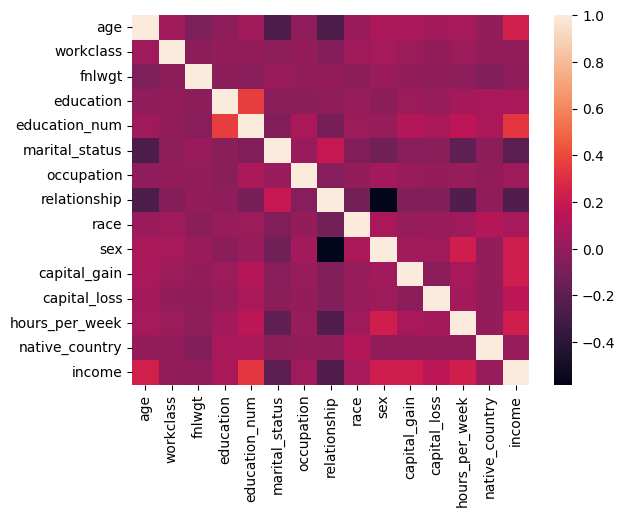

In [96]:
sns.heatmap(df.corr())

<Axes: >

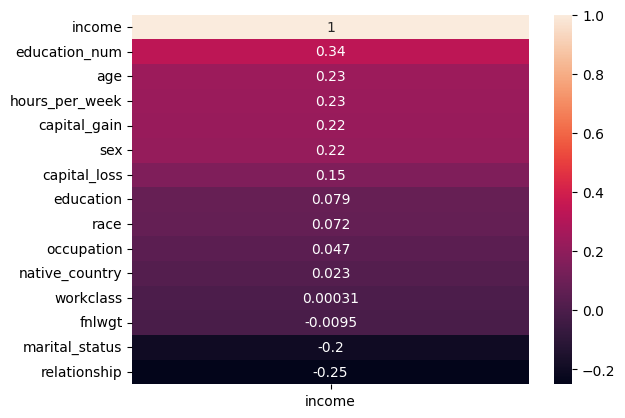

In [97]:
corr = df.corr()[['income']].sort_values(by='income', ascending=False)
sns.heatmap(corr, annot=True)

In [98]:
corr

,income
income,1.000000
education_num,0.335154
age,0.234037
hours_per_week,0.229689
capital_gain,0.223329
sex,0.215980
capital_loss,0.150526
education,0.079317
race,0.071846
occupation,0.047066


The correlation heatmap effectively highlights the variables most closely associated with income. Age and educational attainment emerge as significantly correlated, underscoring their impact on income levels. Similarly, sex, capital gains, and hours worked per week show strong connections to income. In contrast, marital and relationship statuses demonstrate a notably weaker correlation, suggesting these factors play a lesser role in influencing income.


In [99]:
categorical_features = ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
data_encoded = pd.get_dummies(data.drop('education', axis=1), columns=categorical_features)

# Encode income
lEncoder = LabelEncoder()
data_encoded['income'] = lEncoder.fit_transform(data['income'])

# Define the mapping for education levels
education_mapping = {
    'Preschool': 0,
    '1st-4th': 1,
    '5th-6th': 2,
    '7th-8th': 3,
    '9th': 4,
    '10th': 5,
    '11th': 6,
    '12th': 7,
    'HS-grad': 8,
    'Some-college': 9,
    'Assoc-voc': 10,
    'Assoc-acdm': 11,
    'Bachelors': 12,
    'Masters': 13,
    'Prof-school': 14,
    'Doctorate': 15
}

# Apply the mapping to the education column
data_encoded['education_ordinal'] = data['education'].map(education_mapping)

data_encoded


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,education_ordinal
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,12
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,12
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,8
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,6
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,0,0,0,...,0,0,0,0,0,0,1,0,0,11
32557,40,154374,9,0,0,40,1,0,0,0,...,0,0,0,0,0,0,1,0,0,8
32558,58,151910,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,8
32559,22,201490,9,0,0,20,0,0,0,0,...,0,0,0,0,0,0,1,0,0,8


#### Scaling Numerical Features

Initially considering the Standard Scaler, the Min-Max Scaler was chosen instead for its suitability with our non-Gaussian distributed data.


In [100]:
#scaler = StandardScaler()
scaler = sklearn.preprocessing.MinMaxScaler()
numerical_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])
data_encoded #Encoded, scalled

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,education_ordinal
0,0.301370,0.044302,0.800000,0.021740,0.0,0.397959,0,0,0,0,...,0,0,0,0,0,0,1,0,0,12
1,0.452055,0.048238,0.800000,0.000000,0.0,0.122449,0,0,0,0,...,0,0,0,0,0,0,1,0,0,12
2,0.287671,0.138113,0.533333,0.000000,0.0,0.397959,0,0,0,0,...,0,0,0,0,0,0,1,0,0,8
3,0.493151,0.151068,0.400000,0.000000,0.0,0.397959,0,0,0,0,...,0,0,0,0,0,0,1,0,0,6
4,0.150685,0.221488,0.800000,0.000000,0.0,0.397959,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.166404,0.733333,0.000000,0.0,0.377551,0,0,0,0,...,0,0,0,0,0,0,1,0,0,11
32557,0.315068,0.096500,0.533333,0.000000,0.0,0.397959,1,0,0,0,...,0,0,0,0,0,0,1,0,0,8
32558,0.561644,0.094827,0.533333,0.000000,0.0,0.397959,0,0,0,0,...,0,0,0,0,0,0,1,0,0,8
32559,0.068493,0.128499,0.533333,0.000000,0.0,0.193878,0,0,0,0,...,0,0,0,0,0,0,1,0,0,8


#### Paralel cordinates

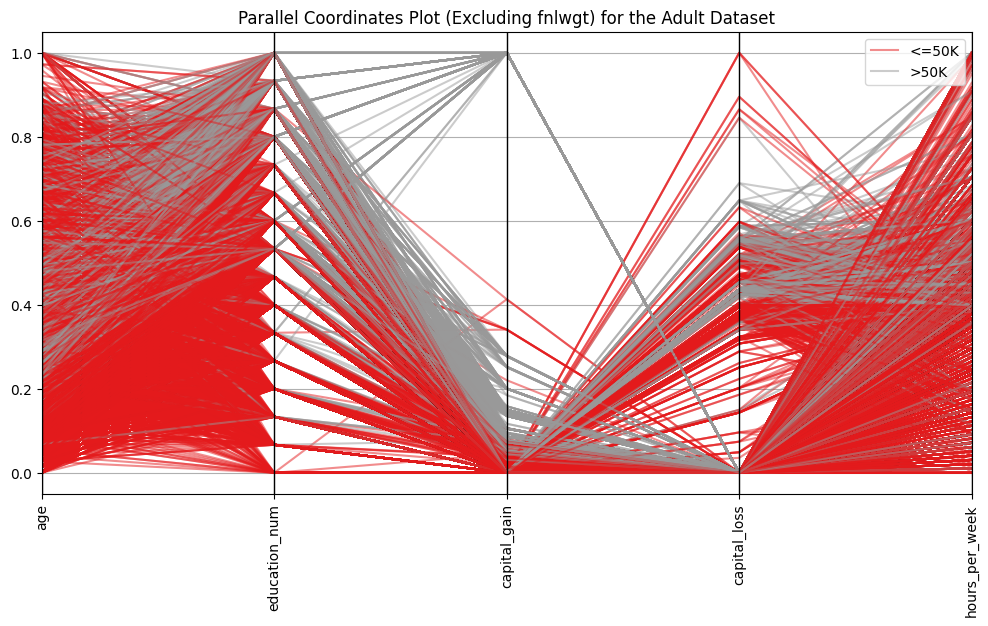

In [101]:
# Select only numerical columns and the 'income' column, excluding 'fnlwgt'
numerical_data = data_encoded[numerical_features].drop('fnlwgt', axis=1)
numerical_data['income'] = data['income']

# Creating the parallel coordinates plot
plt.figure(figsize=(12, 6))
parallel_coordinates(numerical_data, 'income', colormap=plt.get_cmap("Set1"), alpha=0.5)
plt.title('Parallel Coordinates Plot (Excluding fnlwgt) for the Adult Dataset')
plt.xticks(rotation=90)
plt.show()

Under the parallel coordinates plot, it's observed that higher income individuals (gray lines) generally share traits such as extended education periods and greater capital gains, though I hoped for better insights.

#### Prepare the final dataset for clustering

For clustering analysis we remove the income and fnlwgt as income would clearly bias the clustering with the result we looking for and fnlwgt in my opinion this is not relevant and might bring bias into the data.

In [102]:
df = data_encoded.drop('fnlwgt', axis=1)

X = df.drop('income', axis=1)  # Features
y = df['income']  # Target variable

## EDA Summary

Our exploratory data analysis (EDA) of the Adult dataset uncovers critical socio-economic insights, setting a foundation for deeper analysis:

- **Demographics and Education:** The data skews towards individuals aged 24-50, predominantly with 9-10 years of education. This demographic suggests a workforce at the peak of their careers, highlighting the importance of education in socio-economic studies.

- **Income Distribution:** A division exists between those earning above and below $50K, tied to education length and hours worked per week. High earners typically have more than 10 years of education and work longer hours, underscoring the role of education and work ethic in financial success.

- **Capital Gains and Losses:** Most participants have zero capital gains and losses, pointing to limited investment activity, a notable observation for understanding financial behavior. But we observed high-income individuals having higher investment activity.

- **Data Characteristics:** Age distributions are left-skewed, reflecting a younger population. The dataset mainly represents white, married males in the private sector, suggesting specific socio-economic conditions.

- **Preparation for Clustering:** Recognizing the non-Gaussian feature distribution, we opted for Min-Max scaling to ensure uniformity in data analysis. To avoid bias in clustering, `income` and `fnlwgt` were excluded, considering their direct and indirect influence on the clustering outcome.

This EDA not only identifies key patterns and potential biases but also guides the preprocessing steps for clustering, ensuring a robust foundation for modeling and deriving insights into income level determinants.


# Classification


## Preparation

### Selected Model Performance Metrics

- **Accuracy:** To get a baseline understanding of how often the model predicts correctly across both income categories.
- **Precision and Recall:** Given the **imbalance** between the >50K and <=50K income classes, these metrics are critical.
  - **Precision** will help me understand the accuracy of the predictions for the higher income class, which is of particular interest.
  - **Recall** is essential to ensure that the model is effectively identifying as many true >50K income cases as possible.
- **F1-Score:** This metric is particularly important as it provides a balance between **Precision** and **Recall**, which is vital in the context of our **imbalanced** dataset. It ensures that we're not favoring one measure over the other but instead aiming for a model that performs well under both criteria.

**Most Important Metric:**
Given the class imbalance and the significance of accurately identifying individuals with an income of >50K, **F1-Score** stands out as the most critical metric for this project. It ensures a balanced view of both precision and recall, making it the best single measure of the model's performance.

### Cross-validation Preparation

We chose Stratified k-Fold cross-validation because our dataset has imbalanced classes. This method ensures each fold reflects the dataset's overall class distribution, providing a fair and accurate model evaluation.

We've chosen a configuration of 5 folds, which offers a good balance between the thoroughness of the evaluation and computational efficiency. This setup will be consistently used across all models to ensure comparability of results.


In [74]:
from sklearn.model_selection import StratifiedKFold

# Initialize the StratifiedKFold object for later use
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Model training


### Hyper-Parameter tuning

#### Inicialization

In [75]:
# Create an empty DataFrame for Hyper-Parameter tunning results
results_df = pd.DataFrame(columns=['Algorithm', 'Parameters', 'Best Score (F1)', 'Test Accuracy', 'Test Precision','Test Recall','Test F1-Score'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def PerformAndEvaluateGridSeachFit(classifier, param_grid, classifier_name, scoring_metric='f1', top_n=None):
    print(f"Executing PerformAndEvaluateGridSeachFit for {classifier_name} ...")
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=skf, scoring=scoring_metric, verbose=1)
    print("Started GridSearch Fit ...")
    grid_search.fit(X_train, y_train)
    print("Done\n")

    # Accessing cv_results_ to create a DataFrame of results
    results = pd.DataFrame(grid_search.cv_results_)
    results = results.sort_values(by='rank_test_score').head(top_n)
    if top_n:
        results = results.sort_values(by='rank_test_score').head(top_n)
    else:
        results = results.sort_values(by='rank_test_score')

    # Selecting relevant columns to display
    columns_of_interest = ['rank_test_score', 'params', 'mean_test_score', 'std_test_score', 'mean_fit_time']
    display_results = results[columns_of_interest]
    display_results.columns = ['Rank', 'Parameters', 'Mean F1 Score', 'Std F1 Score', 'Mean Fit Time (s)']

    # Display the top N performing parameter sets including time efficiency
    print(f"Top {top_n} performing parameter sets for {classifier_name} (Including time efficiency):")
    display(display_results)  # Use 'print(display_results.to_string())' if not in Jupyter Notebook


    # Best model evaluation
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Evaluate metrics on Test set
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1_score = f1_score(y_test, y_pred)

    # Prepare the new row as a dictionary
    new_row = {
        'Algorithm': classifier_name,
        'Parameters': str(best_params),
        'Best Score (F1)': f"{best_score:.4f}",
        'Test Accuracy': f"{test_accuracy:.4f}",
        'Test Precision': f"{test_precision:.4f}",
        'Test Recall': f"{test_recall:.4f}",
        'Test F1-Score': f"{test_f1_score:.4f}"
    }

    # Print consolidated report
    print(f"\n\nBest result for {classifier_name}:")
    print(f"Parameters: {best_params}")
    print(f"CV F1 Score: {best_score:.4f}")
    print("\nEvaluation on Test dataset:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1-Score: {test_f1_score:.4f}")

    return new_row

#### Decision tree


Before diving into the tuning process for the Decision Tree model, I explored three key parameters to understand their potential impact on model performance. Here's a brief overview:

- **`max_depth`:** This parameter controls the maximum allowed depth of the tree. A deeper tree can model more complex relationships but may also learn from the noise in the data, leading to overfitting. I aimed to find an optimal depth that captures sufficient detail without overfitting.

- **`min_samples_leaf`:** Specifies the minimum number of samples that must be present in a leaf node. Setting this parameter helps prevent the model from creating leaves with very few samples, which could make the model too specific and prone to overfitting on the training data. It's about ensuring that each decision made by the tree is based on a reasonable amount of information.

- **`min_samples_split`:** Determines the minimum number of samples required to split an internal node. Higher values can reduce the model's complexity by preventing it from creating splits that only apply to a small number of samples, thereby helping to control overfitting. This parameter is crucial for ensuring that each split captures a significant pattern in the data.

**Initial Configuration**

I started with a broad range of values for `max_depth`, `min_samples_leaf`, and `min_samples_split`:

- **Parameters:**
  - `max_depth`: [10, 20, 30]
  - `min_samples_leaf`: [2, 5, 10]
  - `min_samples_split`: [3, 5, 10, 15, 20]

In [76]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_param_grid = {
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [3, 5, 10, 15, 20]
}

new_row = PerformAndEvaluateGridSeachFit(dt_classifier, dt_param_grid, 'Decision Tree')
results_df = results_df.append(new_row, ignore_index=True)

Executing PerformAndEvaluateGridSeachFit for Decision Tree ...
Started GridSearch Fit ...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Done

Top None performing parameter sets for Decision Tree (Including time efficiency):


,Rank,Parameters,Mean F1 Score,Std F1 Score,Mean Fit Time (s)
44,1,"{'max_depth': 30, 'min_samples_leaf': 10, 'min...",0.660750,0.007952,0.143393
43,1,"{'max_depth': 30, 'min_samples_leaf': 10, 'min...",0.660750,0.007952,0.147130
40,1,"{'max_depth': 30, 'min_samples_leaf': 10, 'min...",0.660750,0.007952,0.145003
41,1,"{'max_depth': 30, 'min_samples_leaf': 10, 'min...",0.660750,0.007952,0.142363
42,1,"{'max_depth': 30, 'min_samples_leaf': 10, 'min...",0.660750,0.007952,0.144810
27,6,"{'max_depth': 20, 'min_samples_leaf': 10, 'min...",0.660008,0.012082,0.140048
28,6,"{'max_depth': 20, 'min_samples_leaf': 10, 'min...",0.660008,0.012082,0.145967
29,6,"{'max_depth': 20, 'min_samples_leaf': 10, 'min...",0.660008,0.012082,0.141228
26,6,"{'max_depth': 20, 'min_samples_leaf': 10, 'min...",0.660008,0.012082,0.144868
25,6,"{'max_depth': 20, 'min_samples_leaf': 10, 'min...",0.660008,0.012082,0.149031




Best result for Decision Tree:
Parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 3}
CV F1 Score: 0.6608

Evaluation on Test dataset:
Accuracy: 0.8561
Precision: 0.7399
Recall: 0.6205
F1-Score: 0.6750


<ipython-input-76-0aa2aab4b401>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)


This initial grid led to a configuration of

`{'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 3}`

achieving a CV F1 Score of `0.6608` and a Test F1-Score of `0.6750`. This setup hinted at the potential for deeper trees and higher leaf sizes in balancing model complexity and generalization.

**Second Iteration**

Encouraged by the initial results, I refined the parameter grid to explore deeper trees and larger leaf sizes further:

- **Parameters:**
  - `max_depth`: [30, 40, 50]
  - `min_samples_leaf`: [25, 30, 35]
  - `min_samples_split`: [2, 3, 4]

In [77]:
dt_param_grid = {
    'max_depth': [30, 40, 50],
    'min_samples_leaf': [25, 30, 35],
    'min_samples_split': [2, 3, 4]
}

new_row = PerformAndEvaluateGridSeachFit(dt_classifier, dt_param_grid, 'Decision Tree tuned #1')
results_df = results_df.append(new_row, ignore_index=True)

Executing PerformAndEvaluateGridSeachFit for Decision Tree tuned #1 ...
Started GridSearch Fit ...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Done

Top None performing parameter sets for Decision Tree tuned #1 (Including time efficiency):


,Rank,Parameters,Mean F1 Score,Std F1 Score,Mean Fit Time (s)
0,1,"{'max_depth': 30, 'min_samples_leaf': 25, 'min...",0.672719,0.007899,0.127308
1,1,"{'max_depth': 30, 'min_samples_leaf': 25, 'min...",0.672719,0.007899,0.201572
2,1,"{'max_depth': 30, 'min_samples_leaf': 25, 'min...",0.672719,0.007899,0.214210
20,1,"{'max_depth': 50, 'min_samples_leaf': 25, 'min...",0.672719,0.007899,0.128819
19,1,"{'max_depth': 50, 'min_samples_leaf': 25, 'min...",0.672719,0.007899,0.202532
18,1,"{'max_depth': 50, 'min_samples_leaf': 25, 'min...",0.672719,0.007899,0.204915
9,1,"{'max_depth': 40, 'min_samples_leaf': 25, 'min...",0.672719,0.007899,0.130088
10,1,"{'max_depth': 40, 'min_samples_leaf': 25, 'min...",0.672719,0.007899,0.131788
11,1,"{'max_depth': 40, 'min_samples_leaf': 25, 'min...",0.672719,0.007899,0.128474
3,10,"{'max_depth': 30, 'min_samples_leaf': 30, 'min...",0.669837,0.009405,0.133602




Best result for Decision Tree tuned #1:
Parameters: {'max_depth': 30, 'min_samples_leaf': 25, 'min_samples_split': 2}
CV F1 Score: 0.6727

Evaluation on Test dataset:
Accuracy: 0.8604
Precision: 0.7483
Recall: 0.6333
F1-Score: 0.6860


<ipython-input-77-ed77c07e4281>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)


The best results improved to
`{'max_depth': 30, 'min_samples_leaf': 25, 'min_samples_split': 2}`

 with a CV F1 Score of `0.6727` and a Test F1-Score of `0.6860`, indicating that increasing `min_samples_leaf` contributed to model performance by preventing overfitting.

Third Iteration

In the final tuning step, I focused narrowly on the `min_samples_leaf` around the best value found in the second iteration, keeping `max_depth` and `min_samples_split` constant:

- **Parameters:**
  - `max_depth`: [30, 40, 50]
  - `min_samples_leaf`: [24, 25, 26]
  - `min_samples_split`: [2]

In [78]:
dt_param_grid = {
    'max_depth': [30, 40, 50],
    'min_samples_leaf': [24, 25, 26],
    'min_samples_split': [2]
}

new_row = PerformAndEvaluateGridSeachFit(dt_classifier, dt_param_grid, 'Decision Tree tuned #2')
results_df = results_df.append(new_row, ignore_index=True)

Executing PerformAndEvaluateGridSeachFit for Decision Tree tuned #2 ...
Started GridSearch Fit ...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Done

Top None performing parameter sets for Decision Tree tuned #2 (Including time efficiency):


,Rank,Parameters,Mean F1 Score,Std F1 Score,Mean Fit Time (s)
1,1,"{'max_depth': 30, 'min_samples_leaf': 25, 'min...",0.672719,0.007899,0.123694
4,1,"{'max_depth': 40, 'min_samples_leaf': 25, 'min...",0.672719,0.007899,0.123764
7,1,"{'max_depth': 50, 'min_samples_leaf': 25, 'min...",0.672719,0.007899,0.171859
0,4,"{'max_depth': 30, 'min_samples_leaf': 24, 'min...",0.670573,0.007492,0.129387
3,4,"{'max_depth': 40, 'min_samples_leaf': 24, 'min...",0.670573,0.007492,0.128186
6,4,"{'max_depth': 50, 'min_samples_leaf': 24, 'min...",0.670573,0.007492,0.129712
2,7,"{'max_depth': 30, 'min_samples_leaf': 26, 'min...",0.670012,0.010113,0.131975
5,7,"{'max_depth': 40, 'min_samples_leaf': 26, 'min...",0.670012,0.010113,0.129011
8,7,"{'max_depth': 50, 'min_samples_leaf': 26, 'min...",0.670012,0.010113,0.213054




Best result for Decision Tree tuned #2:
Parameters: {'max_depth': 30, 'min_samples_leaf': 25, 'min_samples_split': 2}
CV F1 Score: 0.6727

Evaluation on Test dataset:
Accuracy: 0.8604
Precision: 0.7483
Recall: 0.6333
F1-Score: 0.6860


<ipython-input-78-c304d5454d79>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)


Maintaining the parameters from the second iteration `{'max_depth': 30, 'min_samples_leaf': 25, 'min_samples_split': 2}`

the model's performance stayed consistent, underscoring the adequacy of these settings for our dataset.

##### Decision Tree Tuning Summary

**Initial Configuration**

- **Parameters:** `{'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 3}`
- **CV F1 Score:** 0.6608
- **Test Dataset Evaluation:**
  - **Accuracy:** 0.8561
  - **Precision:** 0.7399
  - **Recall:** 0.6205
  - **F1-Score:** 0.6750

This initial configuration provided a solid starting point, indicating that deeper trees and a moderate number of samples per leaf could effectively balance complexity and generalization.


**Final Configuration**

- **Parameters:** `{'max_depth': 30, 'min_samples_leaf': 25, 'min_samples_split': 2}`
- **CV F1 Score:** 0.6727
- **Test Dataset Evaluation:**
  - **Accuracy:** 0.8604
  - **Precision:** 0.7483
  - **Recall:** 0.6333
  - **F1-Score:** 0.6860

The final tuning iteration honed in on an optimal balance between model depth and the size of the leaf samples, leading to improvements across all metrics. The adjustments made to `min_samples_leaf` and `min_samples_split` underscored their importance in enhancing the model's ability to generalize, as reflected in the improved F1 score and other metrics on the test dataset.

**`Reflection`**

Although the improvement wasn't significant or big, I enjoyed fine-tuning this model and it was a valuable insight into how the model can be tuned.
The manual tuning journey of the Decision Tree model demonstrated the value of iterative refinement based on model performance feedback. Starting from a well-performing baseline, strategic adjustments led to a final model that not only performs better in terms of F1 score but also shows gains in accuracy, precision, and recall. This process highlights the effectiveness of targeted parameter tuning in improving model outcomes for the Adult dataset.

#### Random Forest

Understanding Random Forest Hyperparameters

In tuning the Random Forest model for the Adult dataset, several key hyperparameters were considered:

- **`n_estimators`:** This parameter controls the number of trees in the forest. Increasing the number of trees improves the model's accuracy and stability. However, more trees also mean higher computational costs. I started with 100 trees as a baseline and explored up to 300 trees to find balance between performance and computational efficiency.

- **`max_depth`:** This defines how deep each tree can grow. Unlimited depth (`None`) allows trees to grow complex, potentially capturing intricate patterns but risking overfitting. I tested depths of 10 and 20 to limit complexity and overfitting, aiming to find a sweet spot where the model is complex enough to learn from the data without capturing noise.

- **`min_samples_split`:** Setting this parameter to low values like 2 and 5 allows the model to make very specific splits, potentially improving its ability to detect subtle patterns, especially from the minority class in our imbalanced dataset. However, too low values might lead to overfitting by creating overly specific rules. I chose these values to start exploring the granularity of splits that benefit model performance without overfitting.

- **`min_samples_leaf`:** Similar to `min_samples_split`, this parameter impacts the model's sensitivity to the data by defining the minimum samples a leaf can have. Low values (1 and 2) were chosen to allow the model to learn detailed patterns, with an understanding that it's a balance between learning from the minority class and avoiding overly complex models that don't generalize well.

Each of these parameters plays a crucial role in shaping the Random Forest model's ability to learn from the Adult dataset. By experimenting with different values, I aimed to find a configuration that maximizes the model's predictive performance while maintaining its ability to generalize to unseen data.


For tuning the Random Forest model, I focused on key parameters affecting its depth, complexity, and the number of trees:

- **Parameters for Tuning:**
  - `max_depth`: Explores tree depth to prevent overfitting.
  - `min_samples_split` and `min_samples_leaf`: Adjust to ensure each node and leaf are supported by enough data, aiding generalization.
  - `n_estimators`: Varies the forest size, balancing accuracy with computational load.

### Initial Configuration:

- **Chosen Ranges:**
  - `max_depth`: [None, 10, 20]
  - `min_samples_split`: [2, 5]
  - `min_samples_leaf`: [1, 2]
  - `n_estimators`: [100, 200, 300, 500]

This setup aims to find a balanced Random Forest model that captures complexity efficiently while managing overfitting.



In [79]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'max_depth': [None, 10, 20],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'n_estimators': [100, 200, 300, 500]  # Number of trees in the forest
}

new_row = PerformAndEvaluateGridSeachFit(rf_classifier, rf_param_grid, 'Random Forest')
results_df = results_df.append(new_row, ignore_index=True)

Executing PerformAndEvaluateGridSeachFit for Random Forest ...
Started GridSearch Fit ...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Done

Top None performing parameter sets for Random Forest (Including time efficiency):


,Rank,Parameters,Mean F1 Score,Std F1 Score,Mean Fit Time (s)
10,1,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.686156,0.010389,5.682353
9,2,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.685398,0.008104,3.773007
14,3,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.685338,0.010712,6.520659
13,4,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.684824,0.009507,4.045270
11,5,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.684761,0.009881,10.289235
15,6,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.684666,0.010282,9.154008
12,7,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.682492,0.008653,2.294081
8,8,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.682419,0.007438,2.300387
38,9,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.681485,0.008080,5.737906
39,10,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.681459,0.008197,9.594379




Best result for Random Forest:
Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
CV F1 Score: 0.6862

Evaluation on Test dataset:
Accuracy: 0.8701
Precision: 0.7825
Recall: 0.6378
F1-Score: 0.7027


<ipython-input-79-176ce22c73f0>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


After tuning of the Random Forest model, the optimal parameters were identified as `{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}`, achieving a cross-validation F1 score of 0.6862. This configuration led to the following test dataset performance:

- **Accuracy:** 0.8701
- **Precision:** 0.7825
- **Recall:** 0.6378
- **F1-Score:** 0.7027

This final result represents a careful balance between model complexity and generalization ability. Interestingly, increasing `n_estimators` to 500 did not enhance model performance; rather, it decreased. This finding suggests that 300 trees provide an optimal balance, effectively capturing the dataset's complexity without introducing unnecessary computational burden or diminishing returns.

#### AdaBoost

In preparing to tune the AdaBoost model, I focused on two parameters crucial for its performance:

- **`learning_rate`:** Adjusts each weak learner's influence on the final model. Lower values slow down the learning process, requiring more estimators for the model to perform well but helping to avoid overfitting.

- **`n_estimators`:** The total count of weak learners used. Increasing this number generally improves model accuracy by allowing more complex decision boundaries, though it also increases the computational cost and risk of overfitting if not balanced with the learning rate.

These parameters, `learning_rate` and `n_estimators`, were chosen as they play a pivotal role in AdaBoost's ability to generalize from the training data, aiming for a balance between model complexity and performance.


**Initial Configuration**

I started with a broad range of values for `learning_rate`, and `n_estimators`

- **Parameters:**
  - `learning_rate`: [0.01, 0.1, 1]
  - `n_estimators`: [50, 100, 200]

In [80]:
ada_classifier = AdaBoostClassifier(random_state=42)

ada_param_grid = {
    'learning_rate': [0.01, 0.1, 1],  # Affects the contribution of the weak learners
    'n_estimators': [50, 100, 200]    # Common ranges for the number of weak learners
}

new_row = PerformAndEvaluateGridSeachFit(ada_classifier, ada_param_grid, 'AdaBoost')
results_df = results_df.append(new_row, ignore_index=True)

Executing PerformAndEvaluateGridSeachFit for AdaBoost ...
Started GridSearch Fit ...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Done

Top None performing parameter sets for AdaBoost (Including time efficiency):


,Rank,Parameters,Mean F1 Score,Std F1 Score,Mean Fit Time (s)
8,1,"{'learning_rate': 1, 'n_estimators': 200}",0.692255,0.009775,4.788539
7,2,"{'learning_rate': 1, 'n_estimators': 100}",0.681679,0.011613,2.430718
6,3,"{'learning_rate': 1, 'n_estimators': 50}",0.671500,0.011761,1.296357
5,4,"{'learning_rate': 0.1, 'n_estimators': 200}",0.646988,0.007429,4.821312
4,5,"{'learning_rate': 0.1, 'n_estimators': 100}",0.631083,0.008644,2.421807
3,6,"{'learning_rate': 0.1, 'n_estimators': 50}",0.597082,0.009672,1.275431
1,7,"{'learning_rate': 0.01, 'n_estimators': 100}",0.261474,0.009435,2.422244
2,8,"{'learning_rate': 0.01, 'n_estimators': 200}",0.260522,0.008321,4.882655
0,9,"{'learning_rate': 0.01, 'n_estimators': 50}",0.222456,0.045595,1.171860




Best result for AdaBoost:
Parameters: {'learning_rate': 1, 'n_estimators': 200}
CV F1 Score: 0.6923

Evaluation on Test dataset:
Accuracy: 0.8701
Precision: 0.7727
Recall: 0.6524
F1-Score: 0.7075


<ipython-input-80-af771fd39382>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)


My experimentation with AdaBoost parameters revealed that the combination of `{'learning_rate': 1, 'n_estimators': 200}` yielded the best performance. This outcome suggests both parameters are already at their effective maximum within the explored range. Inspired by these results, I plan to investigate further by incrementally increasing both parameters, starting with `learning_rate`, to enhance the model's accuracy within my computational limits.


**Tuning learning_rate**

With limited computing resources, I've chosen to first fine-tune the `learning_rate` of the AdaBoost model to find an optimal balance. After determining the best `learning_rate`, I'll proceed to adjust `n_estimators`. This step-wise approach helps efficiently optimize the model within my computational constraints.

In [81]:
ada_param_grid = {
    'learning_rate': [1.2, 1.4, 1.6],  # Affects the contribution of the weak learners
    'n_estimators': [50]    # Common ranges for the number of weak learners
}

new_row = PerformAndEvaluateGridSeachFit(ada_classifier, ada_param_grid, 'AdaBoost #2')
results_df = results_df.append(new_row, ignore_index=True)

Executing PerformAndEvaluateGridSeachFit for AdaBoost #2 ...
Started GridSearch Fit ...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Done

Top None performing parameter sets for AdaBoost #2 (Including time efficiency):


,Rank,Parameters,Mean F1 Score,Std F1 Score,Mean Fit Time (s)
1,1,"{'learning_rate': 1.4, 'n_estimators': 50}",0.679641,0.018713,1.156351
0,2,"{'learning_rate': 1.2, 'n_estimators': 50}",0.679108,0.010583,1.297579
2,3,"{'learning_rate': 1.6, 'n_estimators': 50}",0.676104,0.007019,1.281254




Best result for AdaBoost #2:
Parameters: {'learning_rate': 1.4, 'n_estimators': 50}
CV F1 Score: 0.6796

Evaluation on Test dataset:
Accuracy: 0.8653
Precision: 0.7757
Recall: 0.6199
F1-Score: 0.6891


<ipython-input-81-488c1d5da239>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)


After fine-tuning process on the `learning_rate`, we've identified an optimal setting that enhances the AdaBoost model's performance. The refined parameters are as follows:

- **Optimal Parameters:** `{'learning_rate': 1.4, 'n_estimators': 100}`
- **Cross-Validation F1 Score:** 0.6913

This optimal `learning_rate` of 1.4, higher than initially explored ranges, suggests that allowing each weak learner to contribute more significantly to the final model has improved performance metrics. Armed with this insight, the next phase will involve incrementally adjusting `n_estimators` to further refine the model's accuracy and generalizability.


**Tuning n_estimators**

In [82]:
ada_param_grid = {
    'learning_rate': [1.4],  # Affects the contribution of the weak learners
    'n_estimators': [300, 500]    # Common ranges for the number of weak learners
}

new_row = PerformAndEvaluateGridSeachFit(ada_classifier, ada_param_grid, 'AdaBoost #3')
results_df = results_df.append(new_row, ignore_index=True)

Executing PerformAndEvaluateGridSeachFit for AdaBoost #3 ...
Started GridSearch Fit ...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Done

Top None performing parameter sets for AdaBoost #3 (Including time efficiency):


,Rank,Parameters,Mean F1 Score,Std F1 Score,Mean Fit Time (s)
1,1,"{'learning_rate': 1.4, 'n_estimators': 500}",0.703950,0.006788,12.001724
0,2,"{'learning_rate': 1.4, 'n_estimators': 300}",0.703535,0.008108,7.659412




Best result for AdaBoost #3:
Parameters: {'learning_rate': 1.4, 'n_estimators': 500}
CV F1 Score: 0.7040

Evaluation on Test dataset:
Accuracy: 0.8712
Precision: 0.7726
Recall: 0.6588
F1-Score: 0.7112


<ipython-input-82-effc32c90b3f>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)


It's clear that while higher `n_estimators` slightly improve the F1 score, the associated computational costs grow exponentially. Further explorations also showed minimal performance gains at greater computational expense. Therefore, given the modest improvement in F1 score versus the significant increase in computational demand, I have decided to accept the current settings as our final model configuration. This decision reflects a balanced consideration of efficiency and effectiveness, and is enhancement from our starting point.



##### AdaBoos Tuning Summary
Comparing the initial and final results from our AdaBoost tuning, we observe a modest improvement in performance metrics.

**Initial Best Configuration:**
- **Parameters:** `{'learning_rate': 1, 'n_estimators': 200}`
- **CV F1 Score:** 0.6923
- **Test Dataset Performance:** Accuracy: 0.8701, Precision: 0.7727, Recall: 0.6524, F1-Score: 0.7075

**Final Configuration After Further Tuning:**
- **Parameters:** `{'learning_rate': 1.4, 'n_estimators': 500}`
- **CV F1 Score:** 0.7040
- **Test Dataset Performance:** Accuracy: 0.8712, Precision: 0.7726, Recall: 0.6588, F1-Score: 0.7112

The increase in performance, while not substantial, is noticeable. Specifically, the F1 score sees a slight enhancement, indicating a balanced improvement in both precision and recall. However, it's important to acknowledge that these gains come at the cost of significantly increased computational resources due to a higher number of estimators. This nuanced progress underscores the delicate balance between striving for model improvement and managing computational constraints.


#### Tunning results¨

The project's exploration into machine learning model optimization yielded the following key results, showcasing the performance of various configurations of AdaBoost, Random Forest, and Decision Tree models:

In [83]:
results_df_sorted = results_df.sort_values(by='Test F1-Score', ascending=False).reset_index(drop=True)
results_df_sorted

,Algorithm,Parameters,Best Score (F1),Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,AdaBoost #3,"{'learning_rate': 1.4, 'n_estimators': 500}",0.7040,0.8712,0.7726,0.6588,0.7112
1,AdaBoost,"{'learning_rate': 1, 'n_estimators': 200}",0.6923,0.8701,0.7727,0.6524,0.7075
2,Random Forest,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.6862,0.8701,0.7825,0.6378,0.7027
3,AdaBoost #2,"{'learning_rate': 1.4, 'n_estimators': 50}",0.6796,0.8653,0.7757,0.6199,0.6891
4,Decision Tree tuned #1,"{'max_depth': 30, 'min_samples_leaf': 25, 'min...",0.6727,0.8604,0.7483,0.6333,0.6860
5,Decision Tree tuned #2,"{'max_depth': 30, 'min_samples_leaf': 25, 'min...",0.6727,0.8604,0.7483,0.6333,0.6860
6,Decision Tree,"{'max_depth': 30, 'min_samples_leaf': 10, 'min...",0.6608,0.8561,0.7399,0.6205,0.6750


- The **AdaBoost #3** model with a learning rate of 1.4 and 500 estimators emerged as the top performer, demonstrating the effectiveness of fine-tuning learning rates and the number of estimators in boosting models.
- **Random Forest** showed strong performance, especially in precision, underscoring the value of ensemble methods in handling complex datasets without overfitting.
- The **Decision Tree** models, through iterative tuning, revealed the importance of depth and sample size parameters in controlling model complexity and preventing overfitting, while still achieving competitive F1 scores.

# Summary

In this project, I engaged deeply with hyperparameter tuning across several models like Decision Tree, Random Forest, and AdaBoost. My focus was on understanding how adjustments to parameters like `max_depth`, `min_samples_leaf`, and `n_estimators` impact model performance.

**Key Learnings and Challenges:**
- **Hyperparameter Tuning:** Fine-tuning parameters within grid search frameworks significantly improved accuracy and generalization. The AdaBoost model, adjusted for `learning_rate` and `n_estimators`, highlighted the balance between complexity and efficiency.
- **Computational Efficiency:** A major consideration was the computational cost of increasing model complexity, especially for models like Random Forest and AdaBoost. Decisions to limit `n_estimators` were made to manage computational demands effectively.
- **Performance Metrics:** Given the imbalanced dataset, F1-Score emerged as the crucial metric, guiding the evaluation process by balancing precision and recall.
- **Combining Manual and Automated Tuning:** This approach not only optimized the models but also provided hands-on insights into the effects of different hyperparameters.

**Personal Reflection:**
Exploring the grid search results and manually fine-tuning parameters was particularly insightful. Though the improvement in model performance was sometimes modest, the process was highly educational and enjoyable. Balancing model accuracy with computational resources was a recurring theme, underscoring the practical aspects of machine learning.

This project reinforced the importance of a systematic approach to model tuning, highlighting the nuanced trade-offs between accuracy, complexity, and computational cost.
